# Modelagem de Tópicos

### Bibliotecas importantes:

1. tm: https://cran.r-project.org/web/packages/tm/tm.pdf
2. topicmodels: https://cran.r-project.org/web/packages/topicmodels/topicmodels.pdf

### Importando bibliotecas a serem usadas

In [0]:
install.packages("topicmodels")
install.packages('SnowballC')
install.packages('tidytext')
install.packages("LDAvis")
install.packages("tsne")
install.packages("XML")
install.packages("RCurl")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [0]:
suppressMessages(suppressWarnings(library(topicmodels)))
suppressMessages(suppressWarnings(library(tm)))
suppressMessages(suppressWarnings(library(dplyr)))
suppressMessages(suppressWarnings(library(SnowballC)))
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(tidyr)))
suppressMessages(suppressWarnings(library(plyr)))
suppressMessages(suppressWarnings(library(reshape2)))
suppressMessages(suppressWarnings(library(ggplot2)))
suppressMessages(suppressWarnings(library(tidytext)))
suppressMessages(suppressWarnings(library(LDAvis)))
suppressMessages(suppressWarnings(library(RCurl)))
suppressMessages(suppressWarnings(library(XML)))

### Download dos dados
Importe aqui seu dataset de texto.

In [0]:
#Capturando notícias do G1 através da leitura do RSS disponibilizado

getDadosRss <- function(url) {
    script  <- getURL(url)
    doc     <- xmlParse(script)
    feed_title    <- xpathSApply(doc,'//channel/title',xmlValue)
    feed_link    <- xpathSApply(doc,'//channel/link',xmlValue)
    item_titles    <- xpathSApply(doc,'//item/title',xmlValue)
    item_description    <- xpathSApply(doc,'//item/description',xmlValue)
    item_link    <- xpathSApply(doc,'//item/link',xmlValue)
    item_data_published <- xpathSApply(doc,'//item/pubDate',xmlValue)
    item_category <- xpathSApply(doc,'//item/category',xmlValue)

    doc <- data.frame(feed_title=feed_title,feed_link=feed_link,item_titles=item_titles,
                       item_description=item_description,item_data_published=item_data_published,item_link=item_link,
                       item_category=item_category)
  
    # Removendo noticias que são chamadas para outras páginas
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^VÍDEOS:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^VÍDEO:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^AO VIVO:"))
    doc <- doc %>% filter(!str_detect(doc$item_titles, "^Assista ao Jornal"))

    # Removendo link das imagens
    doc$item_description <- str_replace_all(doc$item_description, "<img\\ssrc.*/>","")

    # Removendo sentenças comuns a todos os textos
    remove_sentences <- function(x) {
      x <- str_replace_all(x,"Tem alguma notícia para compartilhar[?]","")
      x <- str_replace_all(x,"Envie para o Tô Na Rede!","")
      x <- str_replace_all(x,'"',"'")
      x <- str_replace_all(x,"‘","'")
      x <- str_replace_all(x,"’","'")
      x <- str_replace_all(x,"“","'")
      x <- str_replace_all(x,"”","'")
      x <- str_trim(x)
    }
    doc$item_description <- lapply(doc$item_description,remove_sentences)

    paste0(doc$item_titles," ",doc$item_description)
}

#Capturando notícias do G1 através da leitura de RSS

dados <- getDadosRss("https://pox.globo.com/rss/g1/")
#dados <- append(dados,getDadosRss("https://pox.globo.com/rss/g1/brasil/"))


In [145]:
dados

[1] "Trailer se desprende de caminhão e atinge casa na Avenida John Boyd Dunlop, em Campinas Incidente ocorreu na tarde deste sábado (22) e causou danos. Ninguém ficou ferido. O trailer de um caminhão se desprendeu do veículo e atingiu uma casa na Avenida John Boyd Dunlop, em Campinas (SP), na tarde deste sábado (22). Ninguém ficou ferido.\nCom o impacto, um trecho da calçada e o portão do imóvel ficaram destruídos. \nIncidente ocorreu na tarde deste sábado, na Avenida John Boyd Dunlop\nReprodução / EPTV\nO motorista caminhão contou à EPTV, afiliada da TV Globo, que levou uma 'fechada' de um carro quando passava por uma curva na região. \n'Como o veículo é muito longo, eu preciso entrar bem aberto na curva. Ele [motorista do automóvel] quis passar onde não cabia. Aí para não bater e matar ele, eu freei bruscamente. O engate não aguentou, o trailer escapou e fez esse estrago aí', lamentou o condutor Marco Antônio.\nA Defesa Civil esteve no imóvel para fazer uma vistoria e constatou que a estrutura da residência não foi danificada. O dono do caminhão se comprometeu a pagar o conserto.\nTrailer atingiu imóvel em Campinas, na tarde deste sábado\nReprodução / EPTV\nMotorista alegou que sofreu 'fechada' antes de incidente, em Campinas\nReprodução / EPTV\nVeja mais notícias da região no G1 Campinas."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Transforme seus dados em um corpus
Corpus é um conjunto de textos. Nesse contexto, corpus é o objeto da biblioteca tm criado para tratar os textos. 

In [146]:
source <- VectorSource(dados)
corpus <- Corpus(source)
corpus

inspect(corpus[1:length(corpus)])

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 35

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 35

 [1] Trailer se desprende de caminhão e atinge casa na Avenida John Boyd Dunlop, em Campinas Incidente ocorreu na tarde deste sábado (22) e causou danos. Ninguém ficou ferido. O trailer de um caminhão se desprendeu do veículo e atingiu uma casa na Avenida John Boyd Dunlop, em Campinas (SP), na tarde deste sábado (22). Ninguém ficou ferido.\nCom o impacto, um trecho da calçada e o portão do imóvel ficaram destruídos. \nIncidente ocorreu na tarde deste sábado, na Avenida John Boyd Dunlop\nReprodução / EPTV\nO motorista caminhão contou à EPTV, afiliada da TV Globo, que levou uma 'fechada' de um carro quando passava por uma curva na região. \n'Como o veículo é muito longo, eu preciso entrar bem aberto na curva. Ele [motorista do automóvel] quis passar onde não cabia. Aí para não bater e matar ele, eu freei bruscamente. O engate não aguentou, o trailer escapou e fez esse estrago aí', lamento

### Qual a quantidade de documentos no seu corpus?

In [147]:
print(paste0("Neste exemplo e capturando as notícias fornecidas pelo G1 no instante de execução do script, temos um total de ",length(corpus)," documentos."))

[1] "Neste exemplo e capturando as notícias fornecidas pelo G1 no instante de execução do script, temos um total de 35 documentos."


### Preprocessando os dados
Realize aqui os pré-processamentos que você julgar necessário nesse corpus. **Explique suas escolhas.**

In [152]:
#Neste caso adotaremos como premissa serão case insensitive 
corpus <- tm_map(corpus, content_transformer(tolower))
#Outro ponto é a não consideração dos números pois em várias notícias estão citadas datas e valores que não são importantes para a definição do tópico em si
corpus <- tm_map(corpus, removeNumbers)
corpus <- tm_map(corpus, removePunctuation)
corpus <- tm_map(corpus, stripWhitespace)
#Foram acrescentadas algumas stopwords adicionais depois de desenvolvida a primeira análise pois estavam distorcendo as métricas e não representando um
#ponto importante para a definição dos tópicos
stop_words <- c("segundo","ser","ainda","'","-","ª","ºc","º","mil","nº","dia","dias","ano","anos","disse","\"","r","g"," – ","após",
                "dois","três","quatro","cinco","seis","sete","oito","nove","dez","segundafeira","terçafeira","quartafeira","quintafeira","sábado","domingo",
                "neste","podem","pode","acordo","durante","onde","deste")
corpus <- tm_map(corpus, removeWords, c(stop_words,stopwords('portuguese'),stopwords('english')))

inspect(corpus[1:length(corpus)])

Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, removeNumbers):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, removePunctuation):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, stripWhitespace):
“transformation drops documents”Warning message in tm_map.SimpleCorpus(corpus, removeWords, c(stop_words, stopwords("portuguese"), :
“transformation drops documents”

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 35

 [1] trailer desprende caminhão atinge casa avenida john boyd dunlop campinas incidente ocorreu tarde  causou danos ninguém ficou ferido trailer caminhão desprendeu veículo atingiu casa avenida john boyd dunlop campinas sp tarde  ninguém ficou ferido impacto trecho calçada portão imóvel ficaram destruídos incidente ocorreu tarde  avenida john boyd dunlop reprodução eptv motorista caminhão contou eptv afiliada tv globo levou fechada carro passava curva região veículo é longo preciso entrar bem aberto curva motorista automóvel quis passar cabia aí bater matar freei bruscamente engate aguentou trailer escapou fez estrago aí lamentou condutor marco antônio defesa civil imóvel fazer vistoria constatou estrutura residência danificada dono caminhão comprometeu pagar conserto trailer atingiu imóvel campinas tarde  reprodução eptv motorista alegou sofreu fechada antes incidente campinas reproduç

### Crie sua matriz termo-documento. Quantos termos você possui no seu vocabulário?

In [153]:
mat <- DocumentTermMatrix(corpus)
mat

<<DocumentTermMatrix (documents: 35, terms: 2690)>>
Non-/sparse entries: 3857/90293
Sparsity           : 96%
Maximal term length: 19
Weighting          : term frequency (tf)

In [154]:
mat_nosparse <- removeSparseTerms(mat, 0.99)
mat_nosparse <- as.matrix(mat_nosparse)

dim(mat_nosparse)

wordcount <- colSums(mat_nosparse)
topten <- head(sort(wordcount, decreasing=TRUE), 10)

[1]   35 2690

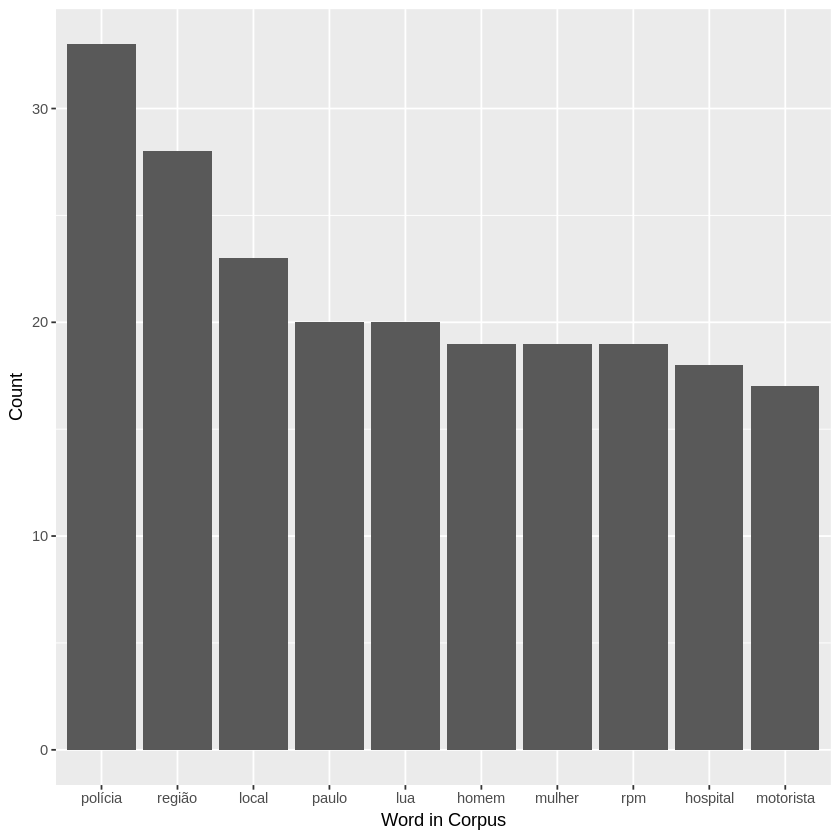

In [155]:
dfplot <- as.data.frame(melt(topten))
dfplot$word <- dimnames(dfplot)[[1]]
dfplot$word <- factor(dfplot$word,
                      levels=dfplot$word[order(dfplot$value,
                                               decreasing=TRUE)])

fig <- ggplot(dfplot, aes(x=word, y=value)) + geom_bar(stat="identity")
fig <- fig + xlab("Word in Corpus")
fig <- fig + ylab("Count")
print(fig)

In [156]:
print(paste0("A matriz termo-documento possui ",dim(mat_nosparse)[2]," termos."))

[1] "A matriz termo-documento possui 2690 termos."


### Descubra o número de tópicos no seu documento. Justifique cada passa e a sua escolha.

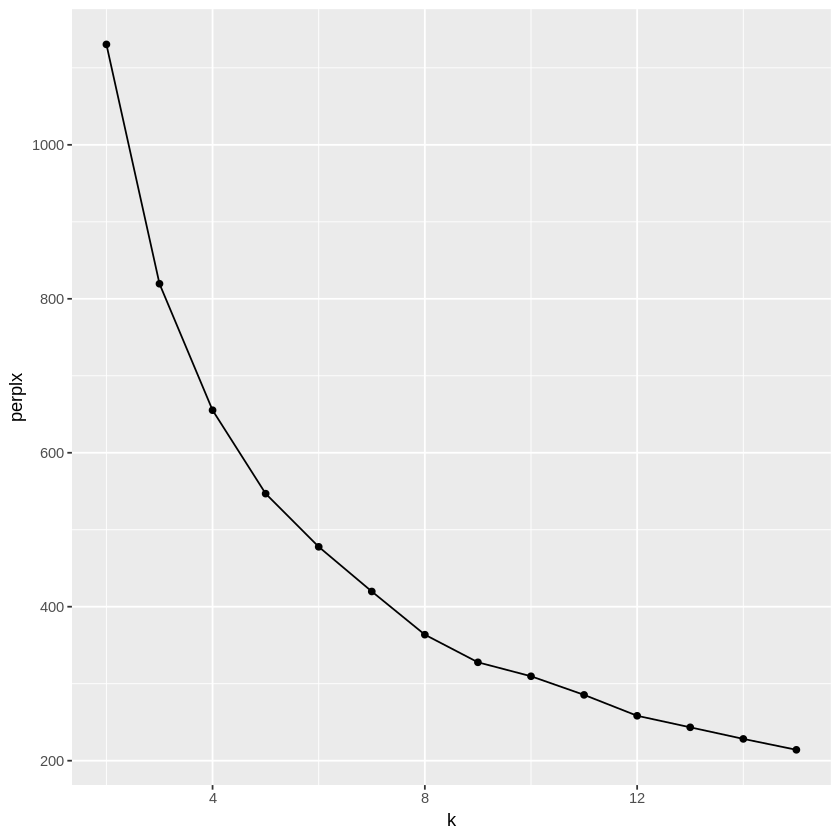

In [206]:
#Criada o gráfico de perplexidade de acordo com o valor k (tópicos) variando de 2 a 15 por exemplo
#pode-se estimar o valor de k que represente ainda um ganho relevante com o aumento do número de tópicos 
k <- c(2:15)
perplx <- c()

for (i in k){
  lda <- LDA(mat, k = i)
  perplx <- c(perplx, perplexity(lda, newdata = mat))
}

ggplot() +
  geom_line(aes(x=k, y=perplx)) +
  geom_point(aes(x=k, y=perplx))

Neste caso, observa-se que a partir do valor de k próximo a 10, temos uma redução no ritmo de queda da perplexidade.

Logo iremos considerar o valor de 10 tópicos para nossa estrutura de documentos.



### Faça a análise dos tópicos criados com o número escolhido acima. Na sua análise apresente os termos mais importantes para cada tópico, nomeie cada tópico e apresente exemplos de documentos que se encaixem muito bem no tópico e outros que nem tanto. Pode adicionar outras informações que achar relevante para que o leitor entenda o que está acontecendo nos seus tópicos.



In [199]:
lda <- LDA(mat, k = 10, control = list(seed = 3421))
lda

A LDA_VEM topic model with 10 topics.

In [200]:
chapter_topics <- tidy(lda, matrix = "beta")

top_terms <- chapter_topics %>%
  group_by(topic) %>%
  top_n(5, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

terms(lda, 5)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
cleusa,rua,caminhões,recife,acidente,irã,lei,polícia,lua,rpm
cuia,local,turistas,bandeiras,rodovia,trabalho,férias,bueiro,wilkins,paulo
mala,parque,prf,procissão,aconteceu,contra,sacolas,touro,ciência,pagni
cabeleireira,prefeitura,cidade,agrônomo,carro,trump,cidade,região,mundo,homem
festa,buracos,caminhão,preto,motorista,região,vai,caiu,terra,hospital


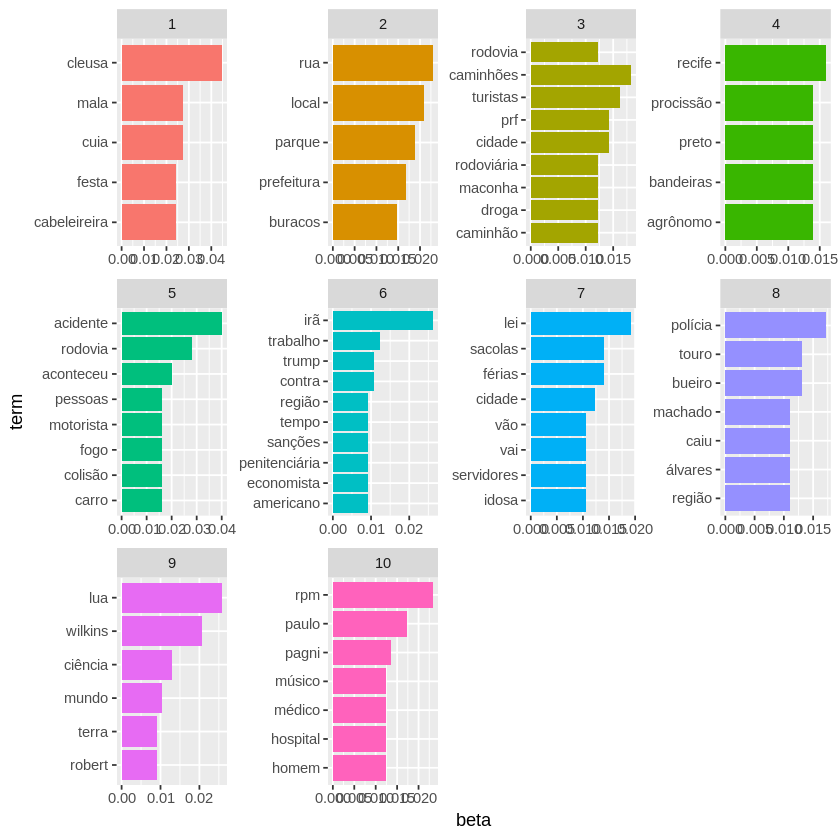

In [201]:
top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()

De acordo com o grupo de palavras principais fornecidas por tópico há uma tendência que sejam relacionados ao assuntos abaixo:

* Tópico 1   - Entretenimento
* Tópico 2   - Cidade
* Tópico 3   - Estradas
* Tópico 4   - Religião
* Tópico 5   - Acidentes
* Tópico 6   - Notícias do Mundo
* Tópico 7   - Legislação
* Tópico 8   - Policial
* Tópico 9   - Ciência e tecnologia
* Tópico 10 - Artistas





In [0]:
label_topicos <- c("Entretenimento","Cidade","Estradas","Religião","Acidentes","Notícias do Mundo","Legislação","Policial","Ciência e tecnologia","Artistas")

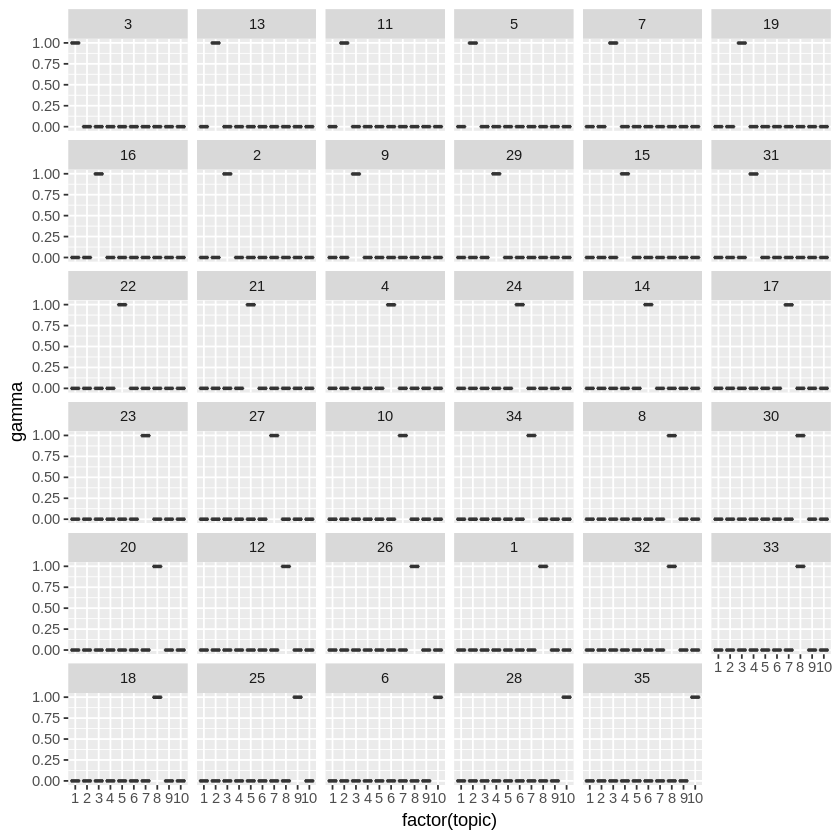

In [203]:
item_gamma <- tidy(lda, matrix = "gamma")

item_gamma %>%
  mutate(document = reorder(document, gamma * topic)) %>%
  ggplot(aes(factor(topic), gamma)) +
  geom_boxplot() +
  facet_wrap(~ document)

In [204]:
# Fazendo a correlação entre os tópicos encontrados por documento

item_classifications <- item_gamma %>%
  group_by(document) %>%
  top_n(1, gamma) %>%
  ungroup()


colnames(item_classifications) <- c("Id_Documento", "Id_Topico", "Gamma")
item_classifications$Topico = label_topicos[as.numeric(item_classifications$Id_Topico)]
item_classifications$Texto = dados[as.numeric(item_classifications$Id_Documento)]
item_classifications

Id_Documento Id_Topico Gamma     Topico              
1  3             1        0.9994794 Entretenimento      
2  5             2        0.9986883 Cidade              
3  11            2        0.9988987 Cidade              
4  13            2        0.9993291 Cidade              
5  2             3        0.9981156 Estradas            
6  7             3        0.9989665 Estradas            
7  9             3        0.9973575 Estradas            
8  16            3        0.9983058 Estradas            
9  19            3        0.9987429 Estradas            
10 15            4        0.9991842 Religião            
11 29            4        0.9993985 Religião            
12 31            4        0.9976819 Religião            
13 21            5        0.9985214 Acidentes           
14 22            5        0.9989735 Acidentes           
15 4             6        0.9977839 Notícias do Mundo   
16 14            6        0.9995129 Notícias do Mundo   
17 24            6        0.9994367 Notícias do Mundo   
18 10            7        0.9988987 Legislação          
19 17            7        0.9974892 Legislação          
20 23            7        0.9978773 Legislação          
21 27            7        0.9985636 Legislação          
22 34            7        0.9992377 Legislação          
23 1             8        0.9987735 Policial            
24 8             8        0.9976457 Policial            
25 12            8        0.9985498 Policial            
26 18            8        0.9989222 Policial            
27 20            8        0.9983246 Policial            
28 26            8        0.9986411 Policial            
29 30            8        0.9983246 Policial            
30 32            8        0.9988740 Policial            
31 33            8        0.9988740 Policial            
32 25            9        0.9998049 Ciência e tecnologia
33 6            10        0.9979632 Artistas            
34 28           10        0.9995368 Artistas            
35 35           10        0.9996317 Artistas            
   Texto                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Analisando as previsões de associação dos documentos aos tópicos e ao tema definido aos mesmos, vemos que alguns se encaixam perfeitamente ao tópico, por exemplo:

* Tópico 1 - Entretenimento -> Documento: 1
* Tópico 2 - Cidade -> Documentos: 5, 11 e 13
* Tópico 3 - Estradas -> Documentos: 2, 9, 16, 19
* Tópico 4 - Religião -> Documentos: 15
* Tópico 5 - Acidentes  -> Documentos: 21, 22
* Tópico 6 - Notícias do Mundo  -> Documento: 14
* Tópico 7 - Legislação  -> Documentos: 10, 34
* Tópico 8 - Policial  -> Documentos: 8, 12, 26, 32, 33
* Tópico 9 - Ciência e Tecnologia  -> Documento: 25
* Tópico 10 - Artistas  -> Documento: 35

Ou seja, dos 35 documentos analisados temos 21 que se encaixam (60%).






## Referências

1. https://rstudio-pubs-static.s3.amazonaws.com/163802_0f005a14bcfb4c4b8ee17ac8a8e6c3e9.html
2. https://www.tidytextmining.com/topicmodeling.html#lda-on-chapters
3. http://freerangestats.info/blog/2017/01/05/topic-model-cv
